<a href="https://colab.research.google.com/github/zw123han/CohereForAI-Scholars-2023/blob/main/C4AIScholarsChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Background**

Welcome to the C4AI Scholars Program Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of different challenges including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Testing your ability to generate code for a specified problem.
*   An opportunity for you to attempt an optional challenge question that extends the original problem set.

These tasks were chosen as a setting to see how you think about problems, even if they are not in your own research field of interest. The tasks and dataset are not meant to be indicative of the research goals of the Scholar Program. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources (can be run in this colab).

Good luck!

**How to Use and Submit this Document?**

*   **Make a copy of this document** and rename it **Firstname_Lastname_C4AIScholarsChallenge**
*   Once you have completed all tasks, save and pin your revisions
*   Submit the assignment by responding directly to the email you received (please reply all) with a link to your final document by Friday September 29th at 12pm PDT.

# **Universal sentence embeddings background [2 points]**
In this takehome, we will be exploring different ways of learning sentence embeddings. Sentence embedding is the collective name for a set of techniques in natural language processing (NLP) where sentences are mapped to vectors of real numbers. For an overview of sentence embeddings and some common methods, we refer these articles: [link1](https://txt.cohere.com/sentence-word-embeddings/), [link2](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a)  

Q1: What are some real world applications of dense sentence embeddings?

Answer: (1) Information retrieval, eg. for retrieval-augmented generation where we want to find the most relevant chunks of text to put into an LLMs context window and adapt to user information. (2) Clustering/unsupervised scientific analysis, where we want to groups of similar behaviour. For example, do people of certain groups or cohorts write similarly? (3) Sentiment/polarization (metric-based) analysis, if the sentence embedding from a pretrained model is a good representation we can use these as input features to a simpler regression model rather than learn from the raw text features.

Q2: Apart from using large language models, what are other ways to compute sentence embeddings?

Answer: We can use unsupervised models such as GloVE (https://nlp.stanford.edu/projects/glove/), which focuses on decomposing the co-occurrence matrix of tokens in a corpus rather than the supervised language-model objective. However, LLMs remain the most popular and state-of-the-art method in the field.

**Imports**

In [ ]:
%pip install transformers

In [ ]:
import json
import math
from collections import OrderedDict
import torch
from torch import nn, Tensor
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import AdamW
from torch.utils.data import DataLoader
from scipy.stats import pearsonr, spearmanr
import numpy as np
import gzip, csv
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer

torch.manual_seed(0)
np.random.seed(0)

## **Coding Challenge Part 1: Debugging custom BERT code [8 points]**

BERT ([Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805)) is a transformer based language model that is pretrained to generate contextualized embeddings. In this part, we provide a BERT implementation together with a pretrained checkpoint file. This BERT implementation includes 8 bugs in which some of these bugs break the code but some of them only impact the model performance.

Tasks:
* [**7 points**] Your goal is to get the code working. There are 7 bugs in the code, some of them lead to error in the code but some of them are designed to impair test accuracy but not break the code. You will one point for each of the 8 bugs you find.

* [**1 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs.


Note for usage and comparison:
*   In order to test this implementation, we provide ***bert_tiny.bin*** and example usage in the below cells.
*   You can check if your bugfixes are correct based on your results in "Coding challenge Part 2". Except the Bert imlementation, there is no bugs in other parts, so if your fixes are correct you should achieve the same results. We provide the expected results for you to compare.


**Please DO NOT use any additional library except the ones that are imported!!**

### Summary of bugs
1. LayerNorm: Mean reduction was incorrectly applied along batch dimension (dim=0). We want to apply along dim=-1 to compute mean/std per token.
2. LayerNorm: Normalizaton formula incorrectly written as x + u, when it should be x - u (representing x - E[x]).
3. Layer: Query-key multiplication is incorrect, should be Q @ K.transpose(-2, -1) instead of Q @ K.
4. Layer: Masked attention weights are set to "inf" instead of "-inf". We want "-inf" so the masked logits become 0 after softmax.
5. Layer: Missing softmax(dim=-1) in attention. (row-wise softmax).
6. Layer: Missing residual add before norm for attention and MLP in forward function (PostNorm)
7. BERT: Incorrect combination of token and positional embeddings. They should be added element-wise per token, not concatenated along the last dimension.
8. (not sure if bug): Default dropout 0.9 is incredibly high, reducing to 0.1 in config.

Note: Set model to eval mode, as it defaults to training mode. Also, added imports for AutoTokenizer from transformer.

I have added some light documentation to each of the functions.

In [ ]:
def gelu(x):
    """Gaussian linear unit activation. https://paperswithcode.com/method/gelu
    Applied element-wise.
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


class Config(object):
    def __init__(self,
                vocab_size,
                hidden_size=768,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                dropout_prob=0.1, # change from 0.9 -> 0.1
                max_position_embeddings=512,
                type_vocab_size=2,
                initializer_range=0.02):

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = dropout_prob
        self.attention_probs_dropout_prob = dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.type_vocab_size = type_vocab_size
        self.initializer_range = initializer_range

    @classmethod
    def from_dict(cls, dict_object):
        config = Config(vocab_size=None)
        for (key, value) in dict_object.items():
            config.__dict__[key] = value
        return config


class LayerNorm(nn.Module):
      """LayerNorm. https://paperswithcode.com/method/layer-normalization
      Normalization is applied to each token embedding independently along its hidden dimension, unlike BatchNorm.
      Input shape: B x T x D
      Output shape: B x T x D
      """
      def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon

      def forward(self, x):
        u = x.mean(-1, keepdim=True) #u = x.mean(0, keepdim=True) # BUG #1: along wrong dim, B x T x D -> do it along the last dim
        s = (x - u).pow(2).mean(-1, keepdim=True) #s = (x + u).pow(2).mean(0, keepdim=True) # BUG #2: x - u and wrong dim again, same as below
        x = (x - u) / torch.sqrt(s + self.variance_epsilon) # x = (x + u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta


class MLP(nn.Module):
      """MultiLayer perceptron with expansion (i.e. feedforward network) with GeLU activation.
      Input shape: B x T x D
      Output shape: B x T x D.
      """
      def __init__(self, hidden_size, intermediate_size):
        super(MLP, self).__init__()
        self.dense_expansion = nn.Linear(hidden_size, intermediate_size)
        self.dense_contraction = nn.Linear(intermediate_size, hidden_size)

      def forward(self, x):
        x = self.dense_expansion(x)
        x = self.dense_contraction(gelu(x))
        return x


class Layer(nn.Module):
    """Transformer encoder block which implements PostNorm as introduced in Vaswani et al., 2017
    Transformer: https://arxiv.org/abs/1706.03762
    x = norm(x + attention(x))
    x = norm(x + feedforward(x))
    Input shape: B x T x D
    Output shape: B x T x D
    """
    def __init__(self, config):
        super(Layer, self).__init__()

        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

        self.attn_out = nn.Linear(config.hidden_size, config.hidden_size)
        self.ln1 = LayerNorm(config.hidden_size)

        self.mlp = MLP(config.hidden_size, config.intermediate_size)
        self.ln2 = LayerNorm(config.hidden_size)

    def split_heads(self, tensor, num_heads, attention_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attention_head_size) # B x T x H x D'
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3) # B x T x H x D' -> B x H x T x D'

    def merge_heads(self, tensor, num_heads, attention_head_size):
        tensor = tensor.permute(0, 2, 1, 3).contiguous() # B x H x T x D' -> B x T x H x D'
        new_shape = tensor.size()[:-2] + (num_heads * attention_head_size,) # B x T x D
        return tensor.view(new_shape)

    def attn(self, q, k, v, attention_mask):
        mask = attention_mask == 1
        mask = mask.unsqueeze(1).unsqueeze(2)

        s = torch.matmul(q, k.transpose(-2, -1)) #s = torch.matmul(q, k) # BUG #3: k.transpose()
        s = s / math.sqrt(self.attention_head_size)

        s = torch.where(mask, s, torch.tensor(float('-inf')).to(s.device)) #s = torch.where(mask, s, torch.tensor(float('inf'))) # BUG #4: -inf, not inf

        p = s.softmax(dim=-1) # p = s # BUG #5: forgot softmax
        p = self.dropout(p)

        a = torch.matmul(p, v) # B x H x T x D
        return a

    def forward(self, x, attention_mask):
        q, k, v = self.query(x), self.key(x), self.value(x) # 3 x B x T x D
        q = self.split_heads(q, self.num_attention_heads, self.attention_head_size) # B x H x T x D'
        k = self.split_heads(k, self.num_attention_heads, self.attention_head_size)
        v = self.split_heads(v, self.num_attention_heads, self.attention_head_size)

        a = self.attn(q, k, v, attention_mask) # B x H x T x D'
        a = self.merge_heads(a, self.num_attention_heads, self.attention_head_size)
        a = self.attn_out(a)
        a = self.dropout(a)
        a = self.ln1(x + a) #a = self.ln1(x) # BUG #6: forgot residual add for attn and mlp

        m = self.mlp(a)
        m = self.dropout(m)
        m = self.ln2(a + m) #m = self.ln2(m) # same bug as above

        return m


class Bert(nn.Module):
      """
      BERT model with CLS-token, as described in Devlin et al., 2018
      https://arxiv.org/abs/1810.04805

      Input: B x T, a set of token ids, attention_mask: B x T, which tokens to ignore in attention
      Output: B x D, a projected vector derived from the CLS token
      """
      def __init__(self, config_dict):
        super(Bert, self).__init__()
        self.config = Config.from_dict(config_dict)
        self.embeddings = nn.ModuleDict({
          'token': nn.Embedding(self.config.vocab_size, self.config.hidden_size, padding_idx=0),
          'position': nn.Embedding(self.config.max_position_embeddings, self.config.hidden_size),
          'token_type': nn.Embedding(self.config.type_vocab_size, self.config.hidden_size),
        })

        self.ln = LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)

        self.layers = nn.ModuleList([
            Layer(self.config) for _ in range(self.config.num_hidden_layers)
        ])

        self.pooler = nn.Sequential(OrderedDict([
            ('dense', nn.Linear(self.config.hidden_size, self.config.hidden_size)),
            ('activation', nn.Tanh()),
        ]))

      def forward(self, input_ids, attention_mask=None, token_type_ids=None, ):
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

         # BUG #7: wrong op/dim. should be token_embeds + pos_embeds + type_embeds
        # x = torch.cat((self.embeddings.token(input_ids),
        #                self.embeddings.position(position_ids),
        #                self.embeddings.token_type(token_type_ids)), # what is token_type_ids?
        #               dim=-1)
        x = self.embeddings.token(input_ids) + self.embeddings.position(position_ids) + self.embeddings.token_type(token_type_ids)
        x = self.dropout(self.ln(x))
        for layer in self.layers:
            x = layer(x, attention_mask)

        o = self.pooler(x[:, 0])
        return (x, o)

      def load_model(self, path):
        self.load_state_dict(torch.load(path))
        return self

**Download weights for the custom Bert**

In [ ]:
!wget https://github.com/for-ai/bert/raw/master/bert_tiny.bin

**An example use of pretrained BERT with transformers library to encode a sentence**

In [ ]:
MODEL_NAME = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## IF YOU CANNOT SOLVE PREVIOUS BUGS, USE THE LINE BELOW:
## bert = AutoModel.from_pretrained(MODEL_NAME)

bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin').eval() # set to eval model for output sanity check, otherwise dropout is non-deterministic at inference

#EXAMPLE USE
sentence = 'An example use of pretrained BERT with transformers library to encode a sentence'
tokenized_sample = tokenizer(sentence, return_tensors='pt', padding='max_length', max_length=512)
output = bert(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)

# We use "pooler_output" for simplicity. This corresponds the last layer
# hidden-state of the first token of the sequence (CLS token) after
# further processing through the layers used for the auxiliary pretraining task.
embedding = output[1]
print(f'\nResulting embedding shape: {embedding.shape}')


Resulting embedding shape: torch.Size([1, 128])


In [ ]:
# sanity check: output values compared to pretrained method
from transformers import AutoModel
bert_gt = AutoModel.from_pretrained(MODEL_NAME)
output_gt = bert_gt(input_ids=tokenized_sample['input_ids'],
              attention_mask=tokenized_sample['attention_mask'],)
embedding_gt = output_gt[1]
print(torch.sum(torch.abs(embedding_gt - embedding)))

tensor(1.5986e-05, grad_fn=<SumBackward0>)


# **Coding Challenge Part 2: Evaluate a pretrained BERT model on STS benchmark [4 points]**

**Please do not use additional library except the ones that are imported!!**

In this part, we are going to evaluate a pretrained BERT model on STS benchmark without applying any additional training. For the evaluation we provide Pearson/Spearman correlation functions and cosine similarity method.

Tasks:

*   **[2 Points]** Prepare an evaluation data loader and evaluation loop: Read in the STS data, tokenize it as shown in the example,  generate the dataloader and return Pearson and Spearman correlation scores.
*   **[1 Point]** Implement cosine similarity function, explained as TODO

**[1 Point] Question**: What is the difference between Pearson and Spearman correlation, and why you might want to evaluate using both metrics?

Spearman correlation is non-parameteric as it is based on the rank (ordering) of pairs (x,y) when ranked in their respective datasets, as opposed to the Pearson correlation which is parameteric as it makes some conditional normality of distribution assumptions of y and directly uses (x,y) values. It's helpful to evaluate with both because we cannot always verify the assumptions for our data.

eg. Spearman: (0, 1), (1, 0)

eg. Pearson: (1.3, 0.5), (0.4, 0.6)

**Semantic Textual Similarity (STS) benchmark:**
STS dataset consists of a set of sentence pairs with a semantic similarity scores for each pair. We want to use this dataset to evaluate the quality of a sentence encoder.

Dataset includes:

*   Sentence pair: (sentence1, sentence2)
*   Similarity score: ranging 1 to 5 where 5 corresponds highest similarity
*   Splits: train, dev, test

**Download datasets**

In [ ]:
!wget https://sbert.net/datasets/stsbenchmark.tsv.gz

In [ ]:
data = pd.read_csv('stsbenchmark.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,train,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,train,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,train,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,train,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,train,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
def load_sts_dataset(file_name):
  df = pd.read_csv(file_name, compression='gzip', delimiter='\t', encoding='utf-8', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
  df_train = df[df["split"] == "train"]
  df_test = df[df["split"] == "test"]
  sts_samples = {
      'train': list(zip(df_train["sentence1"], df_train["sentence2"], df_train["score"])),
      'test': list(zip(df_test["sentence1"], df_test["sentence2"], df_test["score"])),
  }
  return sts_samples


def tokenize_sentence_pair_dataset(dataset, tokenizer, max_length=512):
  tokenized_dataset = []
  for row in tqdm(dataset):
    tok1 = tokenizer(row[0], max_length=max_length, padding="max_length", return_tensors="pt") # pad for batching
    tok2 = tokenizer(row[1], max_length=max_length, padding="max_length", return_tensors="pt")
    tokenized_dataset.append((tok1.input_ids.squeeze(), tok1.attention_mask.squeeze(),
                              tok2.input_ids.squeeze(), tok2.attention_mask.squeeze(),
                              row[2]))
  return tokenized_dataset


def get_dataloader(tokenized_dataset, batch_size, shuffle=False):
  return DataLoader(tokenized_dataset, batch_size=batch_size, shuffle=shuffle)


def cosine_sim(a, b):
  """Implements cosine_sim = cos(theta) = <a, b> / max(||a|| * ||b||, 1e-5) (epsilon for numerical stability)
  """
  # a: torch.tensor of shape (B, D)
  # b: torch.tensor of shape (B, D)
  # returns: torch.tensor of shape (B, B)

  # calculate pairwise inner products
  inner_prods = torch.einsum("ik, jk -> ij", a, b) # B x D, B x D -> B x B, equivalent to faster a @ b.transpose()

  # calculate norms
  norm_a = torch.sqrt(torch.einsum("ik, ik -> i", a, a)) # B x D -> B, equivalent to sqrt(a @ a.transpose())
  norm_b = torch.sqrt(torch.einsum("ik, ik -> i", b, b)) # B x D -> B

  # pairwise prod and numerical stability
  norms = torch.clamp(torch.einsum("i, j -> ij", norm_a, norm_b), min = 1e-5) # B x 1, B x 1 -> B x B

  return inner_prods / norms


def eval_loop(model, eval_dataloader, device):
  to_device = lambda x: x.to(device)
  model = model.to(device)
  model.eval() # don't forget, as dropout is enabled for training
  if "model" in dir(model): # handle nested model
    model.model.eval()
  cosine_sims = []
  labels = []
  for batch in tqdm(eval_dataloader):
    input_1, mask_1, input_2, mask_2, label = list(map(to_device, batch))
    # model forward
    with torch.no_grad():
      _, out_1 = model(input_ids = input_1, attention_mask = mask_1)
      _, out_2 = model(input_ids = input_2, attention_mask = mask_2)

      # calculate cosine_sim between embeddings
      sim = torch.diagonal(cosine_sim(out_1, out_2)) # extract only paired similarity
    cosine_sims.extend(sim.tolist())
    labels.extend(label.tolist())

  # calculate correlation of embedding cosine_sim with labelled similarity
  eval_pearson_cosine = pearsonr(cosine_sims, labels).statistic
  eval_spearman_cosine = spearmanr(cosine_sims, labels).statistic

  return [eval_pearson_cosine, eval_spearman_cosine]

**Evaluation**

Expected result:

Pearson correlation: 0.32

Spearman correlation: 0.33

In [ ]:
#INFO: model and tokenizer
model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)

#INFO: load bert
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert = Bert(bert_config).load_model('bert_tiny.bin')

#INFO: load dataset
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')

#INFO: tokenize dataset
tokenized_test = tokenize_sentence_pair_dataset(sts_dataset['test'], tokenizer)

#INFO: generate dataloader
test_dataloader = get_dataloader(tokenized_test, batch_size=1)

#INFO: run evaluation loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
result_from_pretrained = eval_loop(bert, test_dataloader, device)

print(f'\nPearson correlation: {result_from_pretrained[0]:.2f}\nSpearman correlation: {result_from_pretrained[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.32
Spearman correlation: 0.33


# **Coding Challenge Part 3: Learning sentence embeddings using Natural Language Inference (NLI) dataset [4 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

[Conneue et al. (2018)](https://https://arxiv.org/pdf/1705.02364.pdf) showed that a good sentence embedding model can be learned using NLI dataset. This method proposes using a shared encoder to encode both premise and hypothesis and then combine them before using a softmax classifier. Here , we will use a pretrained BERT model as shared encoder.  

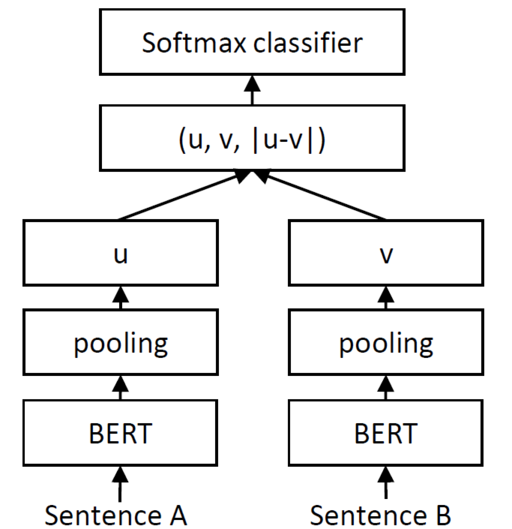

Tasks:

*   **[2 Point]** Prepare a training dataloader and training loop: Read in NLI data, tokenize and generate the corresponding data loader
*   **[2 Point]** BertClassifier: Construct a model that uses above method

**Download NLI dataset**

This dataset includes:
*   Sentence pairs: (sentence1, sentence2)
*   Label: (contradiction, entailment, neutral)
*   Split: train, dev, test

In [ ]:
!wget 'https://sbert.net/datasets/AllNLI.tsv.gz'

In [ ]:
data = pd.read_csv('AllNLI.tsv.gz', nrows=5, compression='gzip', delimiter='\t')
data.head()

,split,dataset,filename,sentence1,sentence2,label
0,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,train,SNLI,snli_1.0_train,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,train,SNLI,snli_1.0_train,Children smiling and waving at camera,They are smiling at their parents,neutral
4,train,SNLI,snli_1.0_train,Children smiling and waving at camera,There are children present,entailment


### Method
We simply use the CLS token extracted from BERT for two sentences (u, v) (sharing the encoder), concat <u, v, u - v> (size: 3 x hidden_dim), then pass through a newly initialized linear layer, followed by a softmax across three classes, with cross entropy loss.

In [ ]:
def load_nli_dataset(file_name):
  df = pd.read_csv(file_name, compression='gzip', delimiter='\t', encoding='utf-8', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
  df["score"] = df["label"].map({ # ordinal mapping
      "contradiction": 0,
      "neutral": 1,
      "entailment": 2
  })
  df_train = df[df["split"] == "train"]
  df_test = df[df["split"] == "test"]
  nli_samples = {
      'train': list(zip(df_train["sentence1"], df_train["sentence2"], df_train["score"])),
      'test': list(zip(df_test["sentence1"], df_test["sentence2"], df_test["score"])),
  }

  return nli_samples


# A periodic eval on dev test can be added (validation_dataloader)
def train_loop(model, optimizer, train_dataloader, num_epochs, device):
  model = model.to(device)
  model.train()
  if "model" in dir(model): # nested model
    model.model.train()

  to_device = lambda x: x.to(device)

  for epoch in tqdm(range(num_epochs)):
      # epoch
      progress_bar = tqdm(enumerate(train_dataloader), leave=True)
      for i, batch in progress_bar:
        # forward prop & loss
        loss = model(list(map(to_device, batch)))
        progress_bar.set_description(f"Step: {i}, Loss: {loss:.3f}")

        # backprop & transform grads
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


class BertClassifier(nn.Module): # this is actually parameterized loss criterion
  def __init__(self, model, device):
    super().__init__()
    self.device = device
    self.model = model.to(device)
    self.criterion = nn.CrossEntropyLoss().to(device)
    self.linear = nn.Linear(model.config.hidden_size * 3, 3)


  def forward(self, batch):
    input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, labels = batch
    _, u = self.model(input_ids = input_ids_1, attention_mask = attention_mask_1)
    _, v = self.model(input_ids = input_ids_2, attention_mask = attention_mask_2)

    # different from original paper: https://arxiv.org/pdf/1705.02364.pdf which uses u * v as a term too
    # unclear the implementation diagram describes
    out = torch.cat([u, v, torch.abs(u - v)], dim=-1)
    logits = self.linear(out)
    loss = self.criterion(logits, labels)
    return loss

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
batch_size = 8
num_labels = 3
hidden_size = 256 # what is this used for? hidden size is suggested to be 128 from pretrained config
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#INFO: load nli dataset
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence length of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=batch_size, shuffle=True)

# INFO: create bert classifier with dual-encoder (shared)
model = Bert(bert_config).load_model(bert_path)
bert_classifier = BertClassifier(model = model, device = device)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_classifier.parameters(), lr=5e-5)
train_loop(bert_classifier, optimizer, train_dataloader, num_epochs, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

**Evaluation**

Expected result:

Pearson correlation: 0.37

Spearman correlation: 0.42

In [ ]:
#TODO: run evaluation loop
result_from_classification = eval_loop(model, test_dataloader, device)
print(f'\nPearson correlation: {result_from_classification[0]:.2f}\nSpearman correlation: {result_from_classification[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.36
Spearman correlation: 0.37


# **Coding Challenge Part 4: Learning sentence embedding using a contrastive approach based on NLI dataset [3 Points]**

**Please DO NOT use additional library except the ones that are imported!!**

In this part, you are asked to explore another method that leverages a contrastive approach using NLI dataset.

Tasks **[3 Points]** :

*   Generate a dataloader if this is required for your approach
*   Construct a BERT based model using a contrastive method

### Contrastive Loss
- The goal is to implement a simple objective that encapsulates the philoshopy of self-supervised learning: minimize energy for similar pairs and maximize energy for unmatched pairs, as described in https://ai.meta.com/blog/self-supervised-learning-the-dark-matter-of-intelligence/
- https://paperswithcode.com/method/supervised-contrastive-loss gives a possible objective formula, which we modify and simplify for just one similarity pair per batch of size N for all pairs u, v in the batch:
$$-1/N [c * sim(paired\_uv) - logsumexp(sim(unpaired\_uv))]$$
- Note: The NLI dataset contains labels which indicates paired sentences are contradictory, hence we want to maximize energy for paired u,v in some cases. Above we denote the possibility of these labels as $$c\in\{-1, 1\}$$

In [ ]:
class BertContrastive(nn.Module):
  def __init__(self, model, device):
    super().__init__()
    self.device = device
    self.model = model.to(device)


  def forward(self, batch):
    input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, labels = batch
    _, u = self.model(input_ids = input_ids_1, attention_mask = attention_mask_1) # u: B x D
    _, v = self.model(input_ids = input_ids_2, attention_mask = attention_mask_2) # u: B x D

    # -1/N (log exp(sim(paired_uv))/sum(exp(sim(unpaired_uv)))) = -1/N (sim(paired_uv) - logsumexp(unpaired_uv))
    sim = cosine_sim(u, v) # B x B
    paired = torch.diag(sim) * torch.where(labels == 0, -1, 1) # B, account for contradictory labels
    unpaired = torch.logsumexp(sim.fill_diagonal_(float("-inf")), dim=-1) # B, mask out paired diagonals
    loss = -1 * torch.mean(paired - unpaired)
    return loss

**Training**

In [ ]:
#INFO: model and training configs
model_name = 'prajjwal1/bert-tiny'
num_epochs = 3
train_batch_size = 8 # TODO increasing batch size may improve perf for contrastive
num_labels =3
hidden_size = 128
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522}
bert_path = 'bert_tiny.bin'

#WARNING: Change this code if you implemented a different nli loader for this part
nli_dataset = load_nli_dataset('AllNLI.tsv.gz')

#INFO: tokenize dataset
#WARNING: Use only first 50000 samples and maximum sequence lenght of 128
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)

#INFO: generate train_dataloader
train_dataloader = get_dataloader(tokenized_train, batch_size=train_batch_size)

#INFO: create a bert contrastive criterion wrapper
model = Bert(bert_config).load_model(bert_path)
bert_contrastive = BertContrastive(model = model, device = device)

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=5e-5)
train_loop(bert_contrastive, optimizer, train_dataloader, num_epochs, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

**Evaluation**

In [ ]:
#TODO: run evaluation loop
result_from_contrastive = eval_loop(model, test_dataloader, device)
print(f'\nPearson correlation: {result_from_contrastive[0]:.2f}\nSpearman correlation: {result_from_contrastive[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.39
Spearman correlation: 0.38


# **Coding Challenge Part 5: Comparison [1 Point]**

In the final part of the coding challenge, you are asked to compare the result of pretrained BERT, classification based BERT, and contrastive method based BERT.

These are the tasks **[1 Point]**:


*   Plot the result for each model
*   Explain the difference between methods and their impact on the result and comparison

### Differences
1. Pretrained BERT: This is BERT trained on masked-language-modelling and next-sentence prediction to learn a good general embedding. It is not tuned for the specific task of similarity embedding.
2. Classification BERT: This model is fully finetuned to classify between three classes: neutral, entailment (similar), and contradition (dissimilar). We can see two of the labels would lead to a correlated representation of similarity embedding, however this is still somewhat misaligned with the objective as it's multiclass label prediction instead of directly training on a similarity objective.
3. Contrastive BERT: This model is finetunend to maximize the cosine similarity for similar pairs of sentences (neutral or entailment) and minimize for dissimilar pairs (unpaired or contradicton). This is the most correlated objective with our human-labelled similarity dataset, hence as expected in the plot of 3 models it generally performs the best out of both correlation metrics.
- Note: There seems to be somewhat high variance between training seeds, for both classification and contrastive losses. (1) Dropout used is very high, this could be the cause. (2) I hypothesize this is due to the small batch sizes which makes each batch very sensitive to the choice of sentences. Sometimes, classification can perform worse than pretrained with the wrong seed.
-Note 2: Not sure why torch and numpy seeds are not allowing reproducibility.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

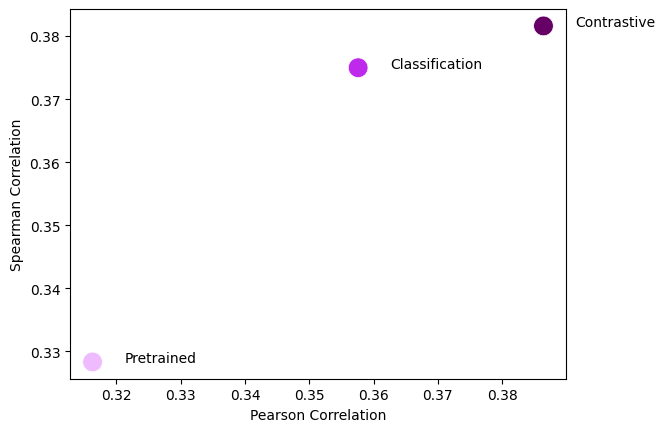

In [ ]:
x = [result_from_pretrained[0], result_from_classification[0], result_from_contrastive[0]] # pearson
y = [result_from_pretrained[1], result_from_classification[1], result_from_contrastive[1]]
z = ["Pretrained", "Classification", "Contrastive"]
df = pd.DataFrame({
    "Pearson Correlation": x,
    "Spearman Correlation": y,
    "Model Type": z,
})
ax = sns.scatterplot(df, x = "Pearson Correlation", y = "Spearman Correlation", c = ["#efbbff", "#be29ec", "#660066"])
ax.collections[0].set_sizes([200])

# label points
for i in range(len(x)):
    ax.text(x[i] + 0.005, y[i], z[i])

# **[OPTIONAL] Explore an alternative way to improve sentence encoder in terms of *performance* or *efficiency* [6 Points]**

Potential directions:
*   Improve the methodology to compute higher quality sentence embeddings  
*   Improve the efficiency during fine-tuning in terms of memory or training time
*   Use different machine learning methods that leverages other resources such as auxillary/teacher models
*   Use different datasets with other training objectives


**You can use any additional model, dataset, library or package for this part!!**

### Method 1: Improve our current training regime
The toy regime we use to train BERT tiny is very unoptimal. We will apply some common techniques for model training to improve performance & efficiency.

- 1. Scheduler: Using a warmup and cosine decay scheduler, which is standard practice when training with adaptive optimizers such as AdamW.
- 2. Dropout: Removing dropout. 0.9 is incredibly aggressive, especially to the attention output, and is causing high variance in our loss. Overfitting may be an issue.
- 3. Batch Size: Increasing batch size to be larger for lower variance gradients. I noticed during training the loss was not decreasing, which indicates our gradients may be too noisy.
- 4. Float16 training: Faster training. Bfloat16 not supported on Colab CUDA.
- 5. Compilation: Using torch.compile on the model which should seamlessly switch our attention to FlashAttn, allowing us to use larger batch sizes without gradient checkpointing.
- 6. Fix dataloader: Enable shuffling and dropping the last batch (to avoid recompile).
- 7. Experiment: For control, let's try these training tricks on our contrastive objective from Part 4, without changing the training dataset.

In [ ]:
!pip install 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts

In [ ]:
# modify train loop to use scheduler, remove dropout, and use float16
def new_train_loop(model, optimizer, scheduler, train_dataloader, num_epochs, device):
  model = model.to(device)
  scaler = torch.cuda.amp.GradScaler()
  model.eval() # a trick to disable dropout, as layernorm behaviour does not change at train/inference
  if "model" in dir(model): # nested model
    model.model.eval()

  to_device = lambda x: x.to(device)

  for epoch in tqdm(range(num_epochs)):
      # epoch
      progress_bar = tqdm(enumerate(train_dataloader), leave=True)
      for i, batch in progress_bar:
        # forward prop & loss
        with torch.amp.autocast(device_type=str(device), dtype=torch.float16): # bfloat16
          loss = model(list(map(to_device, batch)))
        progress_bar.set_description(f"Step: {i}, Loss: {loss:.3f}")

        # backprop & transform grads
        scaler.scale(loss).backward() # TODO bfloat16 may not require scaling
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        optimizer.zero_grad()

In [ ]:
model_name = 'prajjwal1/bert-tiny'
num_epochs = 5 # set to 1 without dropout to avoid overfitting
train_batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_config = {"hidden_size": 128, "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "vocab_size": 30522, "dropout_prob": 0.0}
bert_path = 'bert_tiny.bin'

nli_dataset = load_nli_dataset('AllNLI.tsv.gz')
tokenized_train = tokenize_sentence_pair_dataset(nli_dataset['train'][:50000], tokenizer, max_length=128)
train_dataloader = DataLoader(tokenized_train, batch_size=train_batch_size, shuffle=True, drop_last=True)

model = Bert(bert_config).load_model(bert_path) # TODO need to debug compile for flash attention enablement (torch.sdpa)
bert_contrastive = torch.compile(BertContrastive(model = model, device = device))

#INFO: create optimizer and run training loop
optimizer = AdamW(bert_contrastive.parameters(), lr=1e-4)
scheduler = CosineAnnealingWarmupRestarts(optimizer,
                                          first_cycle_steps=len(train_dataloader) * num_epochs,
                                          cycle_mult=1.0,
                                          max_lr=1e-4,
                                          min_lr=2e-7,
                                          warmup_steps=100,
                                          gamma=1.0)
new_train_loop(bert_contrastive, optimizer, scheduler, train_dataloader, num_epochs, device)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# Let's evaluate if this made a difference
result_from_better_contrastive = eval_loop(model, test_dataloader, device)
print(f'\nPearson correlation: {result_from_better_contrastive[0]:.2f}\nSpearman correlation: {result_from_better_contrastive[1]:.2f}')

  0%|          | 0/1379 [00:00<?, ?it/s]


Pearson correlation: 0.44
Spearman correlation: 0.46


### Performance & Efficiency gains
Note the speedup and performance increase! 0.44 pearson correlation and 0.46 spearman correlation, trained in only ~1.5 minutes including compilation time. That's nearly 10x faster per epoch!
There's a lot more we can do, but for this exercise I'll leave it at these features to keep it brief.

### Method 2: Use a pretrained model (more params + data)
- Existing work shows that language models perform better with more parameters and pretraining data (i.e. neural scaling laws).
- However, training these on the T4 GPU (16GB VRAM) is difficult, especially when combined with limited Colab time and small dataset. We can accelerate training using FlashAttn and PEFT (eg. LoRA) methods, however I have a simpler solution that won't take days to run.
- Instead, let's try to leverage pretrained resources and make them run efficiently. That's the beauty of open-sourcing!
- Currently, the top ranked model on MTEB (massive text-embedding benchmark) is
bge-large-en-v1.5 (https://huggingface.co/BAAI/bge-large-en-v1.5). It's only 326M parameters!

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("BAAI/bge-large-en-v1.5")

NOTE: Redirects are currently not supported in Windows or MacOs.


In [ ]:
# modify eval loop to work with sentence_transformers
def eval_loop(model, eval_dataset, device):
  model = model.to(device)
  model.eval() # don't forget, as dropout is enabled for training
  cosine_sims = []
  labels = []
  for data in tqdm(iter(eval_dataset)):
    sentence_1, sentence_2, label = data
    # model forward
    with torch.no_grad():
      out_1 = model.encode(sentence_1, convert_to_numpy=False).unsqueeze(0)
      out_2 = model.encode(sentence_2, convert_to_numpy=False).unsqueeze(0)


      # calculate cosine_sim between embeddings
      sim = torch.diagonal(cosine_sim(out_1, out_2)) # extract only paired similarity
    cosine_sims.extend(sim.tolist())
    labels.append(label)

  # calculate correlation of embedding cosine_sim with labelled similarity
  eval_pearson_cosine = pearsonr(cosine_sims, labels).statistic
  eval_spearman_cosine = spearmanr(cosine_sims, labels).statistic

  return [eval_pearson_cosine, eval_spearman_cosine]

In [ ]:
sts_dataset = load_sts_dataset('stsbenchmark.tsv.gz')
eval_loop(model, sts_dataset["test"], device)

0it [00:00, ?it/s]

[0.8619879278510055, 0.8751905819261547]

Wow! What a difference a larger model pretrained with more data and a better objective makes! The representation is strong enough to correlate without further finetuning. Looks like we don't need to train our own model after all if we have a good foundation model. Makes you wonder if GPT-4 can few shot prompt its way through this task...